<a href="https://colab.research.google.com/github/sallihin/image-classification/blob/main/training_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Fruits and Vegetable Image Classification

#### Import packages

In [1]:
# Import tensorflow and keras library
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
print("TF version:", tf.__version__)

# Import OS and pathlib module
import os
import pathlib

# Import additional libraries for plotting, eda
# !python -m pip install dask[bag] --upgrade
# !python -m pip install --upgrade Pillow
from dask import bag, diagnostics
from PIL import Image
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
plt.style.use('ggplot')

TF version: 2.7.0


In [2]:
# Check if GPU is running
! nvidia-smi -L

GPU 0: Tesla V100-SXM2-16GB (UUID: GPU-fd2d2515-ed7e-99b8-cf41-37dd514884ae)


#### Load Data

In [3]:
# Link to Google Drive 
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
# File Directory
trainFolder = '/content/drive/MyDrive/DLOR/Assignment/data/train'
validationFolder = '/content/drive/MyDrive/DLOR/Assignment/data/validation'
testFolder = '/content/drive/MyDrive/DLOR/Assignment/data/test'

In [5]:
# Define image height and width
batch_size = 35
img_height = 224
img_width = 224

In [6]:
# Training Set
train_ds = tf.keras.utils.image_dataset_from_directory(
  trainFolder,
  validation_split=0,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 15030 files belonging to 15 classes.


In [7]:
# Validation Set
validation_ds = tf.keras.utils.image_dataset_from_directory(
  testFolder,
  validation_split=0,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3000 files belonging to 15 classes.


In [8]:
# Test Set
test_ds = tf.keras.utils.image_dataset_from_directory(
  testFolder,
  validation_split=0,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3000 files belonging to 15 classes.


#### Exploratory Data Analysis

In [9]:
total_images = len(list(pathlib.Path(trainFolder).glob('*/*.*'))) 
print('Total number of training images: {:,}'.format(total_images))

Total number of training images: 15,010


In [10]:
total_images = len(list(pathlib.Path(validationFolder).glob('*/*.*'))) 
print('Total number of test images: {:,}'.format(total_images))

Total number of test images: 3,000


In [11]:
# Target Classes
class_names = train_ds.class_names
print(class_names)

['Bean', 'Bitter_Gourd', 'Bottle_Gourd', 'Brinjal', 'Broccoli', 'Cabbage', 'Capsicum', 'Carrot', 'Cauliflower', 'Cucumber', 'Papaya', 'Potato', 'Pumpkin', 'Radish', 'Tomato']


In [12]:
print('Total number of categories: {}'.format(len(class_names)))

Total number of categories: 15


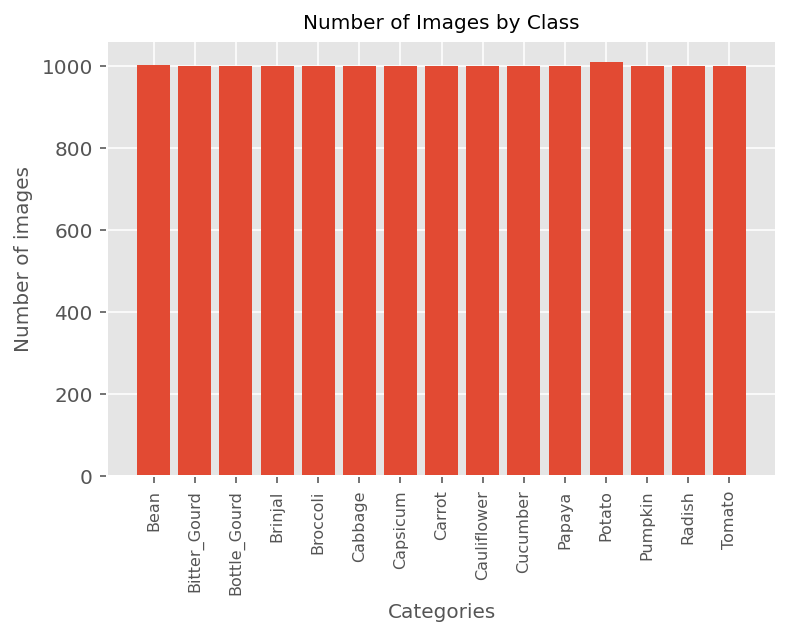

In [ ]:
# Initialize a new dictionary
classes_len = {}

# Find out number of files in each directory
for i in class_names: 
  classes_len[i] = len(os.listdir(trainFolder + ('/') + i))

# Plot the chart
plt.bar(classes_len.keys(), classes_len.values());
plt.title("Number of Images by Class", fontsize = 10);
plt.xticks(rotation=90, fontsize = 8) 
plt.xlabel('Categories', fontsize = 10);
plt.ylabel('Number of images', fontsize = 10);

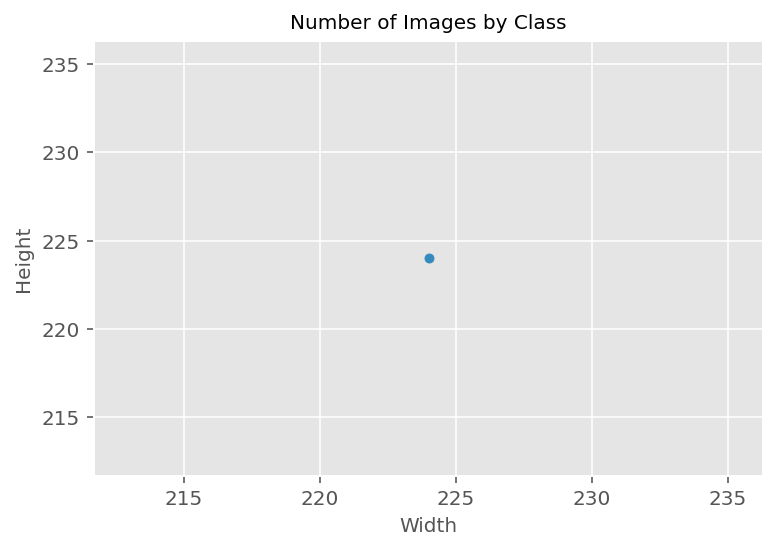

In [ ]:
# Initialize a new dictionary
directories = {}

# Fill dictionary with category names as key and directory as value
for i in class_names: 
  directories[i] = trainFolder + ('/') + i + ('/')

# Gets dimension of RGB image
def get_dims(file):
  im = Image.open(file)
  arr = np.array(im)
  return arr.shape[0], arr.shape[1]

# For each key, value in directory, find each file's dimension
for n,d in directories.items():
  filepath = d
  filelist = [filepath + f for f in os.listdir(filepath)]
  dims = bag.from_sequence(filelist).map(get_dims)
  dims = dims.compute()

# Plot the chart
dim_df = pd.DataFrame(dims, columns=['height', 'width'])
sizes = dim_df.groupby(['height', 'width']).size().reset_index().rename(columns={0:'count'})
sizes.plot.scatter(x='width', y='height');
plt.title("Number of Images by Class", fontsize = 10);
plt.xlabel('Width', fontsize = 10);
plt.ylabel('Height', fontsize = 10);

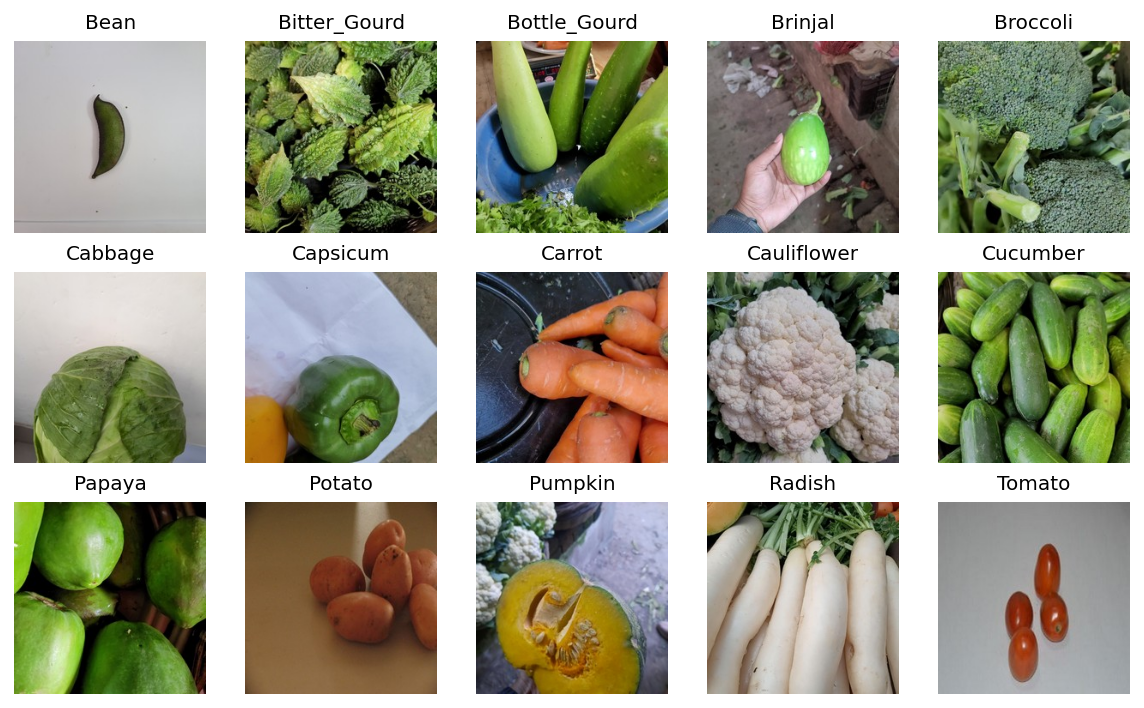

In [ ]:
# Visualise the data 
plt.figure(figsize=(10, 6))
for i in range(len(class_names)): 
  ax = plt.subplot(3, 5, i+1)
  first_image = Image.open(directories.get(class_names[i]) + '0001.jpg')
  plt.imshow(first_image)
  plt.title(class_names[i],fontsize=10)
  plt.axis("off")

#### Data Pre-Processing

In [15]:
# Image augmentation using ImageDataGenerator
datagen = ImageDataGenerator(
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest')

# Load Data 
img = load_img(trainFolder + '/Bean/0001.jpg')  # this is a PIL image
x = img_to_array(img)  # this is a Numpy array with shape (2216, 2218, 3)
x = x.reshape((1,) + x.shape)  # this is a Numpy array with shape (1, 2216, 2218, 3)

# Randomly transform the image based on above parameters 
i = 0
for batch in datagen.flow(x, batch_size=1,
                          save_to_dir=trainFolder + '/Bean/preview', 
                          save_prefix='Image', 
                          save_format='jpg'):
    i += 1
    if i >= 20:
        break  # otherwise the generator would loop indefinitely

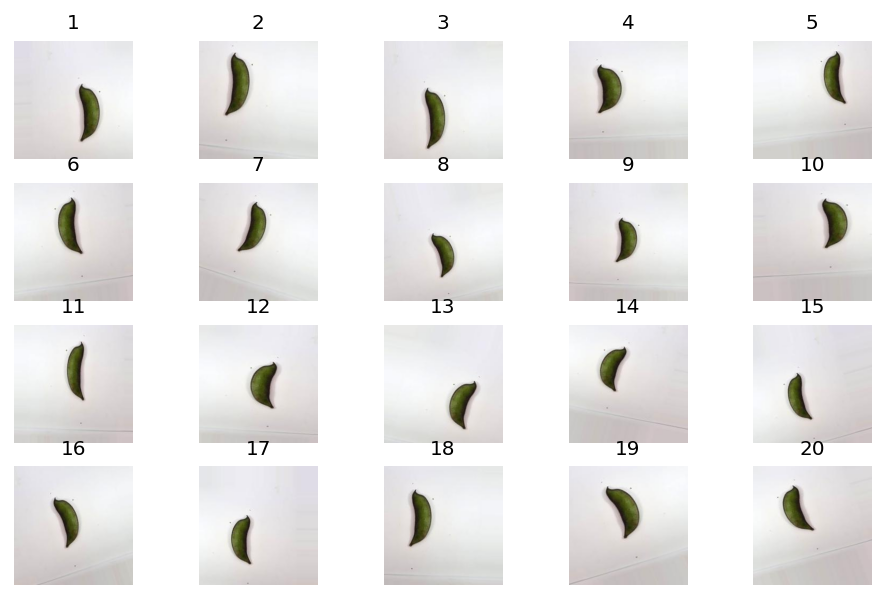

In [ ]:
# Generate a preview of data augmentation
plt.figure(figsize=(8, 5))
preview_folder = os.listdir(trainFolder + '/Bean/preview')
for i in range(len(preview_folder)): 
  ax = plt.subplot(4, 5, i+1)
  preview_image = Image.open(trainFolder + '/Bean/preview/' + preview_folder[i])
  plt.imshow(preview_image)
  plt.title(i+1,fontsize=10)  
  plt.axis("off")

In [13]:
# Data augmentation and rescaling for train
train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)

# Rescaling only for test data
test_datagen = ImageDataGenerator(rescale=1. / 255) 

train_generator = train_datagen.flow_from_directory(
    trainFolder,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical')

validation_generator = test_datagen.flow_from_directory(
    validationFolder,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical')

Found 15030 images belonging to 15 classes.
Found 3000 images belonging to 15 classes.


#### Model Training

In [ ]:
num_classes = len(class_names)

# Instantiate the model
model = tf.keras.Sequential()

# Set input shape
model.add(tf.keras.Input(shape=(img_width, img_height, 3)))

# First set of CONV => RELU => POOL
model.add(tf.keras.layers.Conv2D(16, 3, padding='same'))
model.add(tf.keras.layers.Activation('relu'))
model.add(tf.keras.layers.MaxPooling2D())

# Second set of CONV => RELU => POOL
model.add(tf.keras.layers.Conv2D(32, 3, padding='same'))
model.add(tf.keras.layers.Activation('relu'))
model.add(tf.keras.layers.MaxPooling2D())

# Third set of CONV => RELU => POOL
model.add(tf.keras.layers.Conv2D(64, 3, padding='same'))
model.add(tf.keras.layers.Activation('relu'))
model.add(tf.keras.layers.MaxPooling2D())

# Flatten into 1 dimension Multi Layer Perceptron 
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(128, activation='relu'))

# Classifier
model.add(tf.keras.layers.Dense(num_classes)) 

# Exercise : Complete the activation function of the classifier
model.add(tf.keras.layers.Activation('softmax'))

In [ ]:
model.compile(optimizer='adam',
              loss= 'sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 224, 224, 16)      448       
                                                                 
 activation_4 (Activation)   (None, 224, 224, 16)      0         
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 112, 112, 16)     0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 112, 112, 32)      4640      
                                                                 
 activation_5 (Activation)   (None, 112, 112, 32)      0         
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 56, 56, 32)       0         
 2D)                                                  

In [ ]:
# Train the model 
epochs=10
model_log = model.fit(
  train_ds,
  validation_data=validation_ds,
  epochs=epochs
)

Epoch 1/10
429/429 [==============================] - 15s 33ms/step - loss: 6.3141 - accuracy: 0.5578 - val_loss: 0.8460 - val_accuracy: 0.7420
Epoch 2/10
429/429 [==============================] - 14s 32ms/step - loss: 0.4651 - accuracy: 0.8566 - val_loss: 0.7765 - val_accuracy: 0.7847
Epoch 3/10
429/429 [==============================] - 14s 33ms/step - loss: 0.2510 - accuracy: 0.9231 - val_loss: 1.1223 - val_accuracy: 0.7813
Epoch 4/10
429/429 [==============================] - 14s 33ms/step - loss: 0.1974 - accuracy: 0.9426 - val_loss: 1.0921 - val_accuracy: 0.7507
Epoch 5/10
429/429 [==============================] - 15s 33ms/step - loss: 0.1560 - accuracy: 0.9536 - val_loss: 1.1376 - val_accuracy: 0.7957
Epoch 6/10
429/429 [==============================] - 14s 33ms/step - loss: 0.1162 - accuracy: 0.9683 - val_loss: 1.1509 - val_accuracy: 0.8213
Epoch 7/10
429/429 [==============================] - 14s 32ms/step - loss: 0.1713 - accuracy: 0.9555 - val_loss: 1.1025 - val_accuracy:

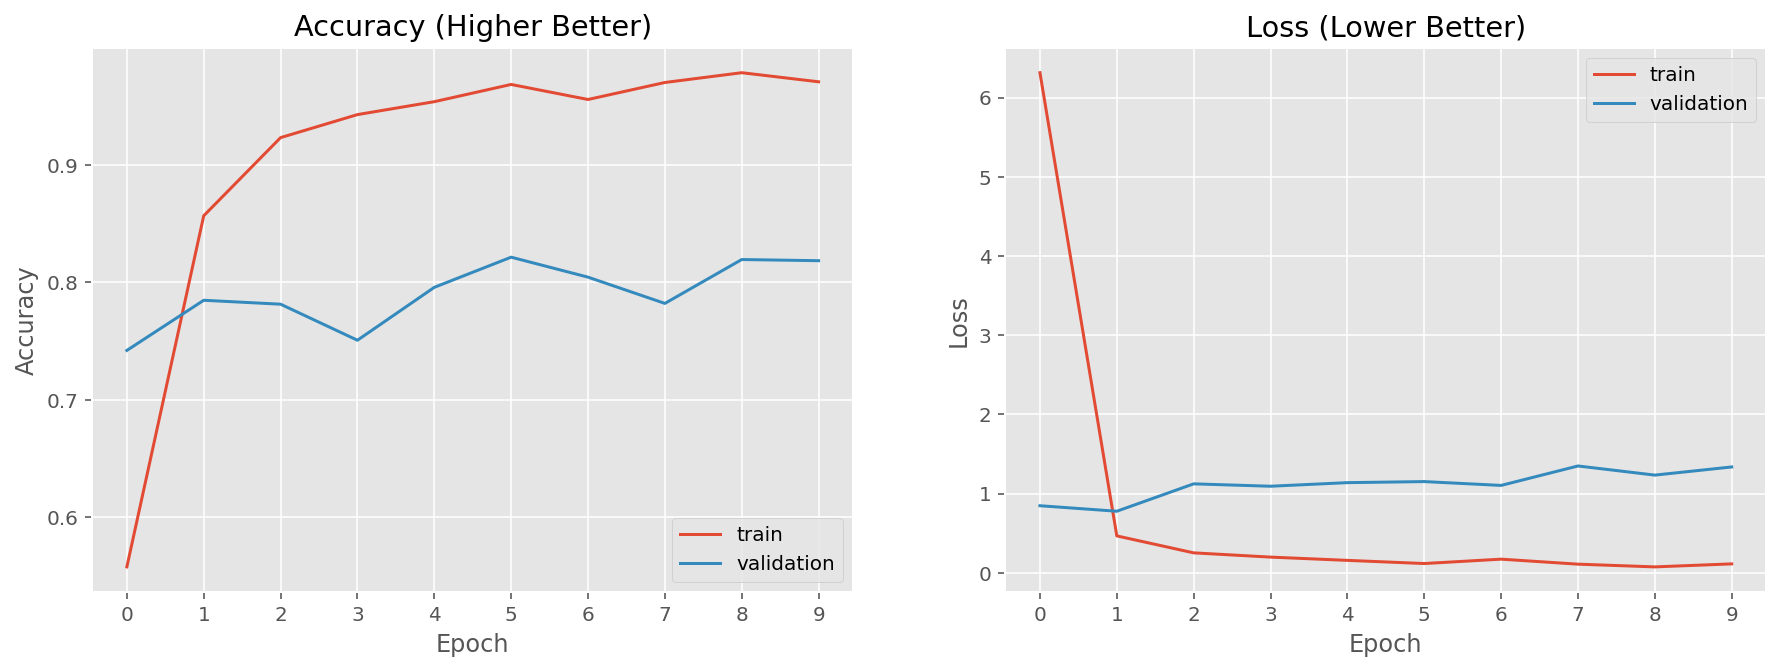

In [ ]:
f, (ax1, ax2) = plt.subplots(1, 2,figsize=(15,5))

ax1.plot(model_log.history['accuracy'])
ax1.plot(model_log.history['val_accuracy'])
ax1.set_title('Accuracy (Higher Better)')
ax1.set(xlabel='Epoch', ylabel='Accuracy')
ax1.legend(['train', 'validation'], loc='lower right')
ax1.xaxis.set_major_locator(MaxNLocator(integer=True))

ax2.plot(model_log.history['loss'])
ax2.plot(model_log.history['val_loss'])
ax2.set_title('Loss (Lower Better)')
ax2.set(xlabel='Epoch', ylabel='Loss')
ax2.legend(['train', 'validation'], loc='upper right')
ax2.xaxis.set_major_locator(MaxNLocator(integer=True))

#### Model Optimisation

In [17]:
num_classes = len(class_names)

# Instantiate the model
ht_model = tf.keras.Sequential()

# Set input shape
ht_model.add(tf.keras.Input(shape=(img_width, img_height, 3)))

# First set of CONV => RELU => POOL
ht_model.add(tf.keras.layers.Conv2D(32, 4, padding='same'))
ht_model.add(tf.keras.layers.Activation('relu'))
ht_model.add(tf.keras.layers.MaxPooling2D())

# Second set of CONV => RELU => POOL
ht_model.add(tf.keras.layers.Conv2D(64, 4, padding='same'))
ht_model.add(tf.keras.layers.Activation('relu'))
ht_model.add(tf.keras.layers.MaxPooling2D())

# Third set of CONV => RELU => POOL
ht_model.add(tf.keras.layers.Conv2D(128, 4, padding='same'))
ht_model.add(tf.keras.layers.Activation('relu'))
ht_model.add(tf.keras.layers.MaxPooling2D())

# Flatten into 1 dimension Multi Layer Perceptron 
ht_model.add(tf.keras.layers.Flatten())
ht_model.add(tf.keras.layers.Dense(128, activation='relu'))
ht_model.add(tf.keras.layers.Dropout(.2))

# Flatten into 1 dimension Multi Layer Perceptron 
ht_model.add(tf.keras.layers.Dense(64, activation='relu'))
ht_model.add(tf.keras.layers.Dropout(.2))

# Classifier
ht_model.add(tf.keras.layers.Dense(num_classes)) 

# Exercise : Complete the activation function of the classifier
ht_model.add(tf.keras.layers.Activation('softmax'))

In [18]:
ht_model.compile(optimizer='adam',
              loss= 'categorical_crossentropy',
              metrics=['accuracy'])

In [19]:
ht_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 224, 224, 32)      1568      
                                                                 
 activation_4 (Activation)   (None, 224, 224, 32)      0         
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 112, 112, 32)     0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 112, 112, 64)      32832     
                                                                 
 activation_5 (Activation)   (None, 112, 112, 64)      0         
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 56, 56, 64)       0         
 2D)                                                  

In [20]:
# Train the model 
epochs=10
model_log = ht_model.fit(
  train_generator,
  validation_data=validation_generator,
  epochs=epochs
)

Epoch 1/10
430/430 [==============================] - 189s 433ms/step - loss: 1.8555 - accuracy: 0.3721 - val_loss: 1.0866 - val_accuracy: 0.6303
Epoch 2/10
430/430 [==============================] - 185s 431ms/step - loss: 1.1267 - accuracy: 0.6339 - val_loss: 0.7147 - val_accuracy: 0.7807
Epoch 3/10
430/430 [==============================] - 185s 430ms/step - loss: 0.8232 - accuracy: 0.7292 - val_loss: 0.5720 - val_accuracy: 0.8190
Epoch 4/10
430/430 [==============================] - 185s 429ms/step - loss: 0.6393 - accuracy: 0.7959 - val_loss: 0.4178 - val_accuracy: 0.8727
Epoch 5/10
430/430 [==============================] - 184s 428ms/step - loss: 0.5606 - accuracy: 0.8228 - val_loss: 0.3456 - val_accuracy: 0.8937
Epoch 6/10
430/430 [==============================] - 185s 429ms/step - loss: 0.4527 - accuracy: 0.8570 - val_loss: 0.2521 - val_accuracy: 0.9317
Epoch 7/10
430/430 [==============================] - 185s 429ms/step - loss: 0.3874 - accuracy: 0.8798 - val_loss: 0.2357 -

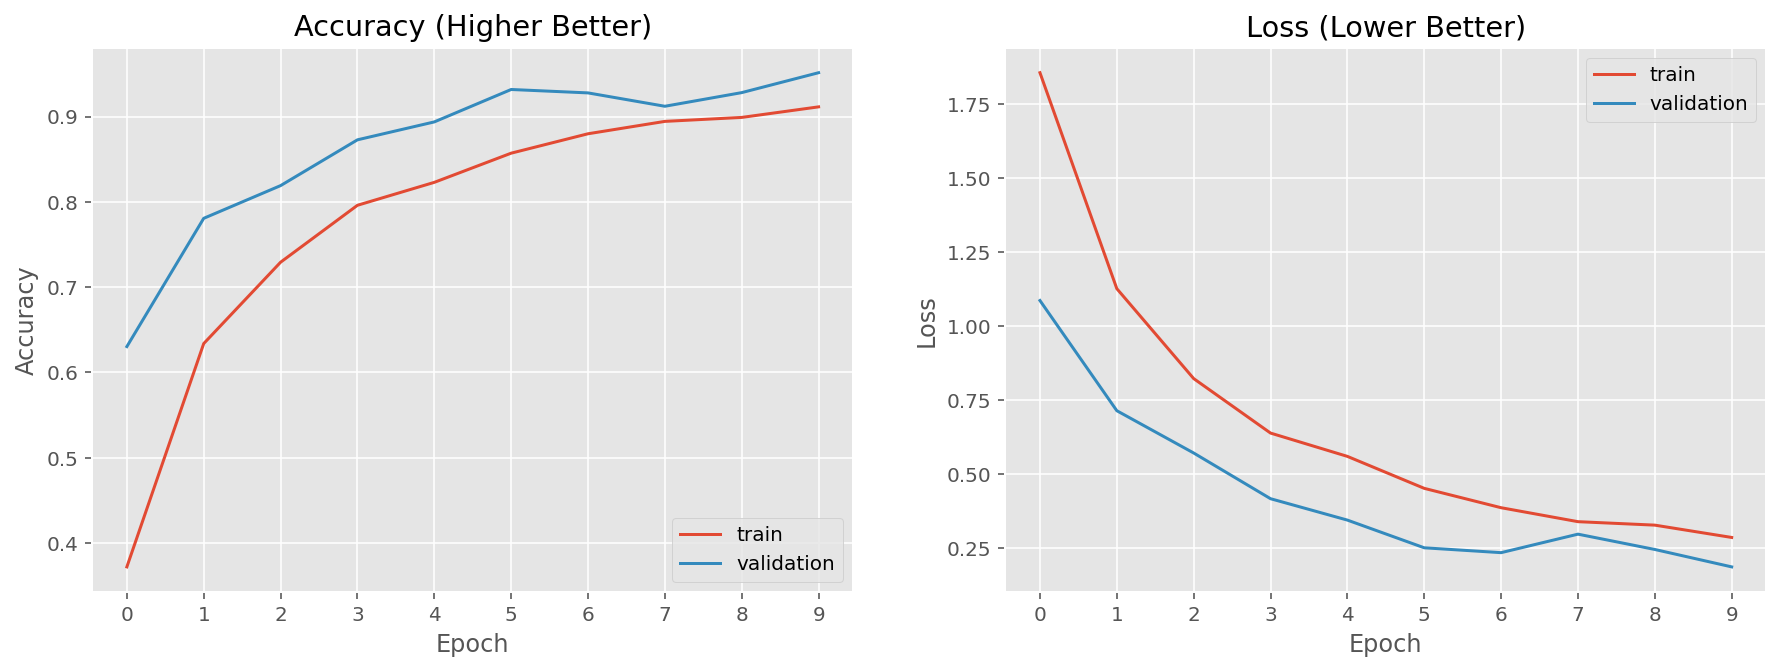

In [21]:
f, (ax1, ax2) = plt.subplots(1, 2,figsize=(15,5))

ax1.plot(model_log.history['accuracy'])
ax1.plot(model_log.history['val_accuracy'])
ax1.set_title('Accuracy (Higher Better)')
ax1.set(xlabel='Epoch', ylabel='Accuracy')
ax1.legend(['train', 'validation'], loc='lower right')
ax1.xaxis.set_major_locator(MaxNLocator(integer=True))

ax2.plot(model_log.history['loss'])
ax2.plot(model_log.history['val_loss'])
ax2.set_title('Loss (Lower Better)')
ax2.set(xlabel='Epoch', ylabel='Loss')
ax2.legend(['train', 'validation'], loc='upper right')
ax2.xaxis.set_major_locator(MaxNLocator(integer=True))

#### Testing The Model

In [25]:
# Predict using image from Google Drive
img = keras.preprocessing.image.load_img(testFolder + '/Bitter_Gourd/1214.jpg', target_size = (img_width, img_height))
img = keras.preprocessing.image.img_to_array(img)
img = np.expand_dims(img, axis = 0)

ht_model.predict(img)

array([[0.0000000e+00, 1.0000000e+00, 0.0000000e+00, 0.0000000e+00,
        0.0000000e+00, 2.4596557e-36, 0.0000000e+00, 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00, 0.0000000e+00]], dtype=float32)

In [24]:
# Predict using image from Google Drive
img = keras.preprocessing.image.load_img(testFolder + '/Tomato/1048.jpg', target_size = (img_width, img_height))
img = keras.preprocessing.image.img_to_array(img)
img = np.expand_dims(img, axis = 0)

ht_model.predict(img)

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]],
      dtype=float32)

#### Output Folders & Files

In [26]:
# createFolder Function
def createFolder (path):
  try:
    os.mkdir(path)
  except:
    print("The folder already exists:", path)
  else:
    print("The folder is created:", path)


In [27]:
# Logs Folder
logsFolder = '/content/drive/MyDrive/DLOR/Assignment/logs'

# Version Control
modelVersion = 'modelv2'    

# Output folder and files 
modelFolder = logsFolder + '/' + modelVersion + '/'
createFolder(modelFolder)
# kerasFile = modelFolder + 'keras_model.h5'
labelFile = modelFolder + 'labels.txt'
tfliteFile = modelFolder + 'trained_model.tflite'

The folder is created: /content/drive/MyDrive/DLOR/Assignment/logs/modelv2/


In [29]:
# Load the keras file, then convert
# keras_model = tf.keras.models.load_model(kerasFile)
converter = tf.lite.TFLiteConverter.from_keras_model(ht_model)
tflite_model = converter.convert()

# Save the model.
with open(tfliteFile, 'wb') as f:
  f.write(tflite_model)

INFO:tensorflow:Assets written to: /tmp/tmp3r36q4wl/assets


In [31]:
testfile = testFolder + '/Bitter_Gourd/1219.jpg'

!python /content/drive/MyDrive/DLOR/Assignment/label_image.py \
--model_file $tfliteFile \
--label_file $labelFile \
--input_mean 1. \
--input_std 1. \
--image $testfile

1.000000: Bitter_Gourd
0.000000: Carrot
0.000000: Capsicum
0.000000: Cabbage
0.000000: Broccoli


In [32]:
testfile = testFolder + '/Potato/1047.jpg'

!python /content/drive/MyDrive/DLOR/Assignment/label_image.py \
--model_file $tfliteFile \
--label_file $labelFile \
--input_mean 1. \
--input_std 1. \
--image $testfile

1.000000: Potato
0.000000: Carrot
0.000000: Capsicum
0.000000: Cabbage
0.000000: Broccoli


In [33]:
testfile = testFolder + '/Tomato/1152.jpg'

!python /content/drive/MyDrive/DLOR/Assignment/label_image.py \
--model_file $tfliteFile \
--label_file $labelFile \
--input_mean 1. \
--input_std 1. \
--image $testfile

1.000000: Tomato
0.000000: Carrot
0.000000: Capsicum
0.000000: Cabbage
0.000000: Broccoli


---

#### **References**

- Dana Rausch, (2021) [EDA for Image Classification](https://medium.com/geekculture/eda-for-image-classification-dcada9f2567a)
- StackExchange, (2018) - [Exploratory Data Analysis with Image Dataset](https://datascience.stackexchange.com/questions/29223/exploratory-data-analysis-with-image-datset)
- Gaurav Singhal, (2020) - [Importing Image Data into NumPy Arrays](https://www.pluralsight.com/guides/importing-image-data-into-numpy-arrays)
- George V Jose (2019) - [Useful Plots to Diagnose your Neural Network](https://towardsdatascience.com/useful-plots-to-diagnose-your-neural-network-521907fa2f45)
- Yong Cui (2020) - [How to Calculate the Number of Parameters in Keras Models](https://towardsdatascience.com/how-to-calculate-the-number-of-parameters-in-keras-models-710683dae0ca)



##### **Dataset**

- Kaggle - [Fruits & Vegetables Image Recognition](https://www.kaggle.com/misrakahmed/vegetable-image-dataset)


##### **Documentation & Libraries**

- [Tensorflow Image Classification](https://www.tensorflow.org/tutorials/images/classification#model_summary)
- [Dask - Parallel Computing](https://docs.dask.org/en/stable/) 
- [Python Imaging Library](https://pillow.readthedocs.io/)
